# Imports and Installs


In [1]:
!pip install datasets
from IPython.display import clear_output
clear_output(wait=True)
print("")

In [2]:
# Import libraries
from datasets import load_dataset
from collections import Counter
import gensim.downloader as api
import re
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Part 0: Dataset Preparation

In [3]:
# Load data func
def load_data():
    dataset = load_dataset("rotten_tomatoes")
    train_dataset = dataset['train']
    validation_dataset = dataset['validation']
    test_dataset = dataset['test']
    return train_dataset, validation_dataset, test_dataset

In [4]:
# Load data
train, valid, test = load_data()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
# Preview first data item
train[0]

{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .',
 'label': 1}

In [6]:
# Preview last data item
train[-1]

{'text': 'things really get weird , though not particularly scary : the movie is all portent and no content .',
 'label': 0}

---
Observation: Dataset text is all
lowercase, with many punctuation, special characters and extra spaces

---



In [7]:
# Preprocess func
def preprocess(text):
    text = re.sub(r"[^a-z0-9'\- ]+", '', text) # Remove punctuation/special chars except ' and -
    text = re.sub(' +', ' ', text) # Remove extra spaces
    return text

def preprocess_dataset(dataset):
    processed_texts = [preprocess(text) for text in dataset['text']]
    return {'text': processed_texts}

In [8]:
# Preprocess
train = train.map(preprocess_dataset, batched=True)
valid = valid.map(preprocess_dataset, batched=True)
test = test.map(preprocess_dataset, batched=True)

In [9]:
# Preview processed first data item
train[0]

{'text': "the rock is destined to be the 21st century's new conan and that he's going to make a splash even greater than arnold schwarzenegger jean-claud van damme or steven segal ",
 'label': 1}

In [10]:
# Preview processed last data item
train[-1]

{'text': 'things really get weird though not particularly scary the movie is all portent and no content ',
 'label': 0}

In [11]:
# Count words
all_train_words = []
for item in train:
    all_train_words.extend(item['text'].split())

vocab = Counter(all_train_words)
print(f"(1a) {len(vocab)}")

(1a) 18730


# Part 1: Preparing Word Embeddings (Word2Vec and GloVe)

In [12]:
# Show list of available embeddings
list(api.info()['models'].keys())

['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']

In [13]:
# Load models func
def load_embeddings_word2vec(embedding_type='word2vec-google-news-300'):
    embeddings = api.load(embedding_type)
    return embeddings

def load_embeddings_glove(embedding_type='glove-wiki-gigaword-300'):
    embeddings = api.load(embedding_type)
    return embeddings

In [14]:
# Load models
embedding_model_word2vec = load_embeddings_word2vec()
embedding_model_glove = load_embeddings_glove()

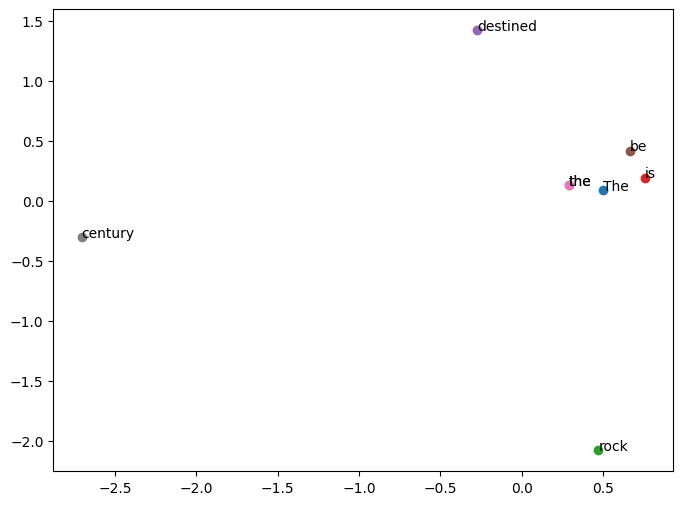

In [15]:
# Visualize embeddings for word2vec
words = ['The', 'the', 'rock', 'is', 'destined', 'be', 'the', 'century']
vectors = [embedding_model_word2vec[word] for word in words]

# PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(vectors)

# Plot
plt.figure(figsize=(8,6))
for i, word in enumerate(words):
    plt.scatter(reduced_vectors[i,0], reduced_vectors[i,1])
    plt.annotate(word, xy=(reduced_vectors[i,0], reduced_vectors[i,1]))
plt.show()



---


Observation: 'to' not in word2vec

---





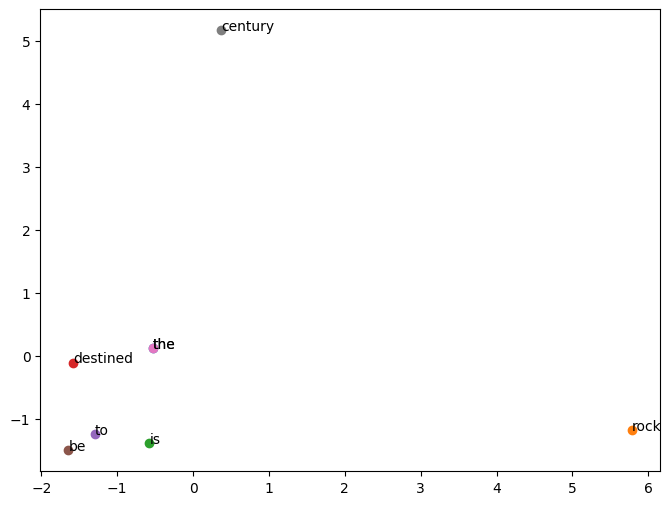

In [16]:
# Visualize embeddings for glove
words = ['the', 'rock', 'is', 'destined', 'to', 'be', 'the', 'century']
vectors = [embedding_model_glove[word] for word in words]
reduced_vectors = pca.fit_transform(vectors)

# Plot
plt.figure(figsize=(8,6))
for i, word in enumerate(words):
    plt.scatter(reduced_vectors[i,0], reduced_vectors[i,1])
    plt.annotate(word, xy=(reduced_vectors[i,0], reduced_vectors[i,1]))
plt.show()


---
Observation: 'The' not in glove

---








---

Observation: Word2vec Embedding is case sensitive, both embeddings and not stemmed or lemmatized, so we dont apply these to our data either

---





In [17]:
# Count oov for word2vec
oov_words_word2vec = []
for word in vocab:
    if word not in embedding_model_word2vec:
        oov_words_word2vec.append(word)

print(f"(1b) {len(oov_words_word2vec)}")

(1b) 4370


In [18]:
# Count oov for glove
oov_words_glove = []
for word in vocab:
    if word not in embedding_model_glove:
        oov_words_glove.append(word)

print(f"(1b) {len(oov_words_glove)}")

(1b) 2841




---


Oberservation: Glove has less OOV words, hence we will proceed with glove embedding model


---



In [19]:
# Create embedding matrix func
def create_embedding_matrix(vocab, embedding_model, embedding_dim=300):
    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    oov_words = []

    for word, idx in vocab.items():
        try:
            embedding_matrix[idx] = embedding_model[word]
        except KeyError:
            oov_words.append(word)
            embedding_matrix[idx] = np.random.normal(size=(embedding_dim,))

    return torch.FloatTensor(embedding_matrix), oov_words

In [20]:
# Create embedding matrix with glove embedding
embedding_matrix, oov_words = create_embedding_matrix(vocab, embedding_model_glove)



---
(1c)
Solution to mitigate OOV words:
1. Look into both embedding models, average the values if its in both, else take the value of the one it is found in.
2. If it is in neither, attempt to find synonyms in WordNet
3. If that does not work, generate n-gram and attempt to use character n-gram to find word
4. If all else fail, return random values


---



In [21]:
# Create the enhanced embedding matrix using both embedding models
def create_embedding_matrix_enhanced(vocab, embedding_model_w2v, embedding_model_glove, embedding_dim=300):
    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    oov_words = []

    for word, idx in vocab.items():
        w2v_vector = embedding_model_w2v[word] if word in embedding_model_w2v else None
        glove_vector = embedding_model_glove[word] if word in embedding_model_glove else None
        if w2v_vector is not None and glove_vector is not None:
            embedding = (w2v_vector + glove_vector) / 2 # Average of both models
        elif w2v_vector is not None:
            embedding = w2v_vector
        elif glove_vector is not None:
            embedding = glove_vector
        else: # Word is OOV
            embedding = handle_oov_word(word, embedding_model_w2v, embedding_model_glove, embedding_dim)
            oov_words.append(word)
        embedding_matrix[idx] = embedding

    return torch.FloatTensor(embedding_matrix), oov_words

# Function to look at OOV words
def handle_oov_word(word, embedding_model_w2v, embedding_model_glove, embedding_dim):
    # Try find synonyms in WordNet
    synonyms = get_synonyms(word)
    synonym_vectors = []
    for synonym in synonyms:
        if synonym in embedding_model_w2v:
            synonym_vectors.append(embedding_model_w2v[synonym])
        elif synonym in embedding_model_glove:
            synonym_vectors.append(embedding_model_glove[synonym])
    if synonym_vectors:
        return np.mean(synonym_vectors, axis=0) # Average the synonyms embeddings

    # Try use character n-grams
    ngram_vectors = []
    ngrams = generate_ngrams(word)
    for ngram in ngrams:
        if ngram in embedding_model_w2v:
            ngram_vectors.append(embedding_model_w2v[ngram])
        elif ngram in embedding_model_glove:
            ngram_vectors.append(embedding_model_glove[ngram])
    if ngram_vectors:
        return np.mean(ngram_vectors, axis=0)  # Average the n-grams embeddings
    return np.random.normal(size=(embedding_dim,)) # If all else fails, initialize randomly

# Function to get synonyms with WordNet
def get_synonyms(word):
    synonyms = set()
    for synset in wn.synsets(word):
        for lemma in synset.lemmas():
            synonym = lemma.name().replace('_', ' ')
            synonyms.add(synonym.lower())
    return synonyms

# Function to generate character n-grams from unigrams to trigrams
def generate_ngrams(word):
    ngrams = []
    n = len(word)
    for i in range(n):
        for j in range(i+1, min(n+1, i+4)): # Generate n-grams of length 1 to 3
            ngram = word[i:j]
            ngrams.append(ngram)
    return ngrams


In [22]:
# Create the embedding matrix with the 2 models
embedding_matrix_enhanced, oov_words_enhanced = create_embedding_matrix_enhanced(vocab, embedding_model_word2vec, embedding_model_word2vec)

# Part 2: Model Training & Evaluation (Base RNN Model)



---

We need to first tokenize and pad the data, then create a dataloader to train the rnn

---



In [23]:
# Tokenize, remove stop words, encoding of tokens and padding func
def tokenize_and_pad(texts, max_length=50):
    all_tokens = []
    stop_words = set(stopwords.words('english'))
    for text in texts:
        tokens = word_tokenize(text)
        tokens = [w for w in tokens if not w.lower() in stop_words]
        all_tokens.append(tokens)

    word_index = {'<PAD>': 0, '<OOV>': 1}

    current_index = 2
    for tokens in all_tokens:
        for token in tokens:
            if token not in word_index:
                word_index[token] = current_index
                current_index += 1

    sequences = [[word_index.get(token, word_index['<OOV>']) for token in tokens] for tokens in all_tokens]

    sequences_tensor = [torch.tensor(seq) for seq in sequences]
    padded_sequences = pad_sequence(sequences_tensor, batch_first=True, padding_value=word_index['<PAD>'])

    return padded_sequences, word_index



---


(2c) Solution to utilize hidden state:

1. `out = self.fc(rnn_out[:, -1])` takes the last hidden state and feeds it to the fully connected layer
2. `out = self.fc(torch.mean(rnn_out, dim=1))` averages all hidden states to consider every word equally
3. `self.attention = nn.Linear(hidden_size, 1)` the attention mechanism assigns weights to different words based on their importance




---



In [24]:
# Def RNN and variants
class SentimentRNN_Freeze(nn.Module):
    def __init__(self, embedding_matrix, hidden_size=128, output_size=1, num_layers=1):
        super().__init__()
        vocab_size, embedding_dim = embedding_matrix.shape

        # FREEZE IS TRUE
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.rnn = nn.RNN(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        rnn_out, _ = self.rnn(embedded)
        out = self.fc(rnn_out[:, -1])
        return out

class SentimentRNN(nn.Module):
    def __init__(self, embedding_matrix, hidden_size=128, output_size=1, num_layers=1):
        super().__init__()
        vocab_size, embedding_dim = embedding_matrix.shape

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.rnn = nn.RNN(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        rnn_out, _ = self.rnn(embedded)
        out = self.fc(rnn_out[:, -1])
        return out

class SentimentRNN_AvgHidden(nn.Module):
    def __init__(self, embedding_matrix, hidden_size=128, output_size=1, num_layers=1):
        super().__init__()
        vocab_size, embedding_dim = embedding_matrix.shape

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.rnn = nn.RNN(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        rnn_out, _ = self.rnn(embedded)
        # Average hidden states
        out = self.fc(torch.mean(rnn_out, dim=1))
        return out

class SentimentRNN_Attention(nn.Module):
    def __init__(self, embedding_matrix, hidden_size=128, output_size=1, num_layers=1):
        super().__init__()
        vocab_size, embedding_dim = embedding_matrix.shape

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.rnn = nn.RNN(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        # Attention layer
        self.attention = nn.Linear(hidden_size, 1)

    def forward(self, x):
        embedded = self.embedding(x)
        rnn_out, _ = self.rnn(embedded)
        # Calculate attention weights, apply attention weights to hidden states
        attention_weights = torch.softmax(self.attention(rnn_out), dim=1)
        out = self.fc(torch.sum(attention_weights * rnn_out, dim=1))
        return out

In [25]:
# Def train/evaluate funcs
def train_model(model, train_loader, val_loader, epochs, learning_rate, optimizer, criterion):
    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0
        epoch_train_acc = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.float().to(device)

            optimizer.zero_grad()
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate training accuracy
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            acc = (preds == labels).float().mean()

            epoch_train_loss += loss.item()
            epoch_train_acc += acc.item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_train_acc = epoch_train_acc / len(train_loader)

        # Validation phase
        model.eval()
        epoch_valid_loss = 0
        epoch_valid_acc = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs = inputs.to(device)
                labels = labels.float().to(device)

                outputs = model(inputs).squeeze(1)
                loss = criterion(outputs, labels)

                # Calculate validation accuracy
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).float()
                acc = (preds == labels).float().mean()

                epoch_valid_loss += loss.item()
                epoch_valid_acc += acc.item()

        avg_valid_loss = epoch_valid_loss / len(valid_loader)
        avg_valid_acc = epoch_valid_acc / len(valid_loader)

        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc*100:.2f}%')
        print(f'Valid Loss: {avg_valid_loss:.4f} | Valid Acc: {avg_valid_acc*100:.2f}%')
    return avg_valid_acc


In [26]:
# Tokenize texts and create dataloaders with it and labels
train_texts = [item['text'] for item in train]
valid_texts = [item['text'] for item in valid]
test_texts = [item['text'] for item in test]

train_labels = [item['label'] for item in train]
valid_labels = [item['label'] for item in valid]
test_labels = [item['label'] for item in test]

train_texts_padded, train_word_index = tokenize_and_pad(train_texts)
valid_texts_padded, valid_word_index = tokenize_and_pad(valid_texts)
test_texts_padded, test_word_index = tokenize_and_pad(test_texts)

train_dataset = TensorDataset(train_texts_padded, torch.tensor(train_labels))
valid_dataset = TensorDataset(valid_texts_padded, torch.tensor(valid_labels))
test_dataset = TensorDataset(test_texts_padded, torch.tensor(test_labels))

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # only need to shuffle train
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [44]:
# Def config
criterion = nn.BCEWithLogitsLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rates = [
    1e-4,
    # 1e-5,
]
optimizers = [
    torch.optim.Adam,
    # torch.optim.SGD,
]
epochs = 20

In [45]:
# Find best config func
import copy

def find_best_config(model_class, embedding_matrix, train_loader, valid_loader, epochs, optimizers, learning_rates, criterion):
    best_accuracy = 0
    best_config = {}
    best_model = None

    for optimizer_class in optimizers:
        print(f"optimizer: {optimizer_class.__name__}")
        for lr in learning_rates:
            print(f"learning rate: {lr}")
            # Instantiate a new model for each configuration
            model = model_class(embedding_matrix)
            model.to(device)
            # Initialize the optimizer
            optimizer = optimizer_class(model.parameters(), lr=lr)

            # Train and Evaluate
            val_accuracy = train_model(model, train_loader, valid_loader, epochs, lr, optimizer, criterion)

            # Update Best Configuration
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_config = {
                    'epochs': epochs,
                    'optimizer': optimizer_class.__name__,
                    'learning_rate': lr,
                    'batch_size': batch_size
                }
                # Save the best model
                best_model = copy.deepcopy(model)

    print(f"Best Configuration: {best_config}, Validation Accuracy: {best_accuracy * 100:.2f}%")
    return best_model, best_config


# Test and visualize func
def test_model(model, test_loader):
    model.eval()
    model_name = model.__class__.__name__
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for texts, labels in test_loader:
            texts = texts.to(device)
            outputs = model(texts).squeeze(1)
            predicted_probs = torch.sigmoid(outputs)
            predicted = (predicted_probs > 0.5).int().cpu().numpy()
            all_preds.extend(predicted)
            all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy for {model_name}: {accuracy * 100:.2f}%")
    print(f"\nClassification Report for {model_name}")
    print(classification_report(all_labels, all_preds))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()




---

(2a, 2b) Best Config and accuracy for RNN model

---



optimizer: Adam
learning rate: 0.0001
Epoch 1/20
Train Loss: 0.6933 | Train Acc: 50.20%
Valid Loss: 0.6937 | Valid Acc: 49.08%
Epoch 2/20
Train Loss: 0.6932 | Train Acc: 50.06%
Valid Loss: 0.6929 | Valid Acc: 51.01%
Epoch 3/20
Train Loss: 0.6932 | Train Acc: 50.29%
Valid Loss: 0.6932 | Valid Acc: 49.08%
Epoch 4/20
Train Loss: 0.6932 | Train Acc: 49.83%
Valid Loss: 0.6929 | Valid Acc: 51.01%
Epoch 5/20
Train Loss: 0.6932 | Train Acc: 50.59%
Valid Loss: 0.6933 | Valid Acc: 49.08%
Epoch 6/20
Train Loss: 0.6931 | Train Acc: 49.83%
Valid Loss: 0.6930 | Valid Acc: 48.99%
Epoch 7/20
Train Loss: 0.6930 | Train Acc: 50.01%
Valid Loss: 0.6930 | Valid Acc: 51.01%
Epoch 8/20
Train Loss: 0.6928 | Train Acc: 50.16%
Valid Loss: 0.6929 | Valid Acc: 51.47%
Epoch 9/20
Train Loss: 0.6926 | Train Acc: 50.30%
Valid Loss: 0.6933 | Valid Acc: 47.66%
Epoch 10/20
Train Loss: 0.6920 | Train Acc: 50.94%
Valid Loss: 0.6930 | Valid Acc: 51.83%
Epoch 11/20
Train Loss: 0.6919 | Train Acc: 50.75%
Valid Loss: 0.6937 |

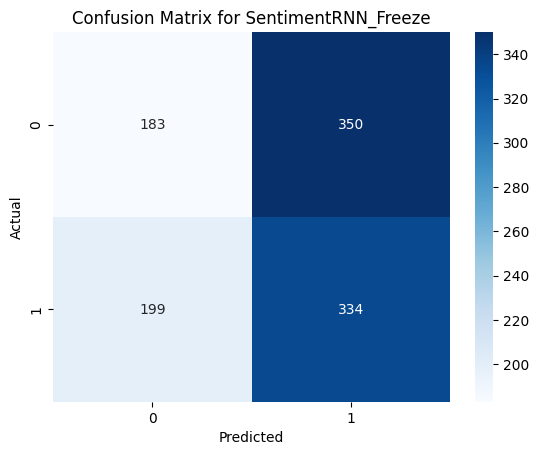

In [46]:
# Train, evaluate and find best config for Frozen embedding matrix
embedding_matrix, oov_words = create_embedding_matrix(vocab, embedding_model_glove)
best_model_Freeze, best_config_Freeze = find_best_config(
    model_class=SentimentRNN_Freeze,
    embedding_matrix=embedding_matrix,
    train_loader=train_loader,
    valid_loader=valid_loader,
    epochs=epochs,
    optimizers=optimizers,
    learning_rates=learning_rates,
    criterion=criterion
)
test_model(best_model_Freeze, test_loader)

# Part 3: Enhancements (Improved RNN Models, BiLSTM, BiGRU, CNN)

In [ ]:
class SentimentBiLSTM(nn.Module):
    def __init__(self, embedding_matrix, hidden_size=128, output_size=1, num_layers=1, bidirectional=True):
        super().__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.rnn = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )
        self.fc = nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.rnn(embedded)
        if self.rnn.bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden = hidden[-1]
        out = self.fc(hidden)
        return out


class SentimentBiGRU(nn.Module):
    def __init__(self, embedding_matrix, hidden_size=128, output_size=1, num_layers=1, bidirectional=True, dropout=0.5):
        super().__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        output, hidden = self.gru(embedded)
        if self.gru.bidirectional or self.gru.num_layers > 1:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden = hidden[-1]
        hidden = self.dropout(hidden)
        out = self.fc(hidden)
        return out

class SentimentCNN(nn.Module):
    def __init__(self, embedding_matrix, output_size=1, num_filters=100, filter_sizes=[3, 4, 5], dropout=0.5):
        super().__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=(fs, embedding_dim))
            for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * num_filters, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.unsqueeze(1)
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = torch.cat(pooled, dim=1)
        cat = self.dropout(cat)
        out = self.fc(cat)
        return out




---


(3a) Results with non-frozen embedding matrix


---



In [ ]:
# Train, evaluate and find best config for non-Frozen embedding matrix
embedding_matrix, oov_words = create_embedding_matrix(vocab, embedding_model_glove)
best_model, best_config = find_best_config(
    model_class=SentimentRNN,
    embedding_matrix=embedding_matrix,
    train_loader=train_loader,
    valid_loader=valid_loader,
    epochs=epochs,
    optimizers=optimizers,
    learning_rates=learning_rates,
    criterion=criterion
)
test_model(best_model, test_loader)

optimizer: Adam
learning rate: 0.0001
Epoch 1/20
Train Loss: 0.6933 | Train Acc: 49.59%
Valid Loss: 0.6934 | Valid Acc: 48.99%
Epoch 2/20
Train Loss: 0.6933 | Train Acc: 50.16%
Valid Loss: 0.6939 | Valid Acc: 48.99%
Epoch 3/20
Train Loss: 0.6932 | Train Acc: 50.26%
Valid Loss: 0.6931 | Valid Acc: 50.92%
Epoch 4/20
Train Loss: 0.6932 | Train Acc: 50.31%
Valid Loss: 0.6934 | Valid Acc: 48.99%
Epoch 5/20
Train Loss: 0.6924 | Train Acc: 50.88%
Valid Loss: 0.6936 | Valid Acc: 48.07%
Epoch 6/20
Train Loss: 0.6634 | Train Acc: 61.69%
Valid Loss: 0.7336 | Valid Acc: 50.23%
Epoch 7/20
Train Loss: 0.5078 | Train Acc: 76.52%
Valid Loss: 0.8758 | Valid Acc: 50.70%
Epoch 8/20
Train Loss: 0.3201 | Train Acc: 87.60%
Valid Loss: 1.0401 | Valid Acc: 50.11%
Epoch 9/20
Train Loss: 0.2064 | Train Acc: 92.83%
Valid Loss: 1.2892 | Valid Acc: 49.78%
Epoch 10/20
Train Loss: 0.1350 | Train Acc: 95.71%
Valid Loss: 1.4766 | Valid Acc: 49.60%
Epoch 11/20
Train Loss: 0.0980 | Train Acc: 97.10%
Valid Loss: 1.6331 |



---

(3b) Results with enhanced embedding matrix for OOV words

---



In [ ]:
# Try enhanced embedding matrix
embedding_matrix_enhanced, oov_words_enhanced = create_embedding_matrix_enhanced(vocab, embedding_model_word2vec, embedding_model_word2vec)
best_model_enhanced, best_config_enhanced = find_best_config(
    model_class=SentimentRNN,
    embedding_matrix=embedding_matrix_enhanced,
    train_loader=train_loader,
    valid_loader=valid_loader,
    epochs=epochs,
    optimizers=optimizers,
    learning_rates=learning_rates,
    criterion=criterion
)
test_model(best_model_enhanced, test_loader)



---

(2c cont) Making use of RNN hidden states

---



In [ ]:
# RNN with average hidden state
embedding_matrix_enhanced, oov_words_enhanced = create_embedding_matrix_enhanced(vocab, embedding_model_word2vec, embedding_model_word2vec)
best_model_AvgHidden, best_config_AvgHidden = find_best_config(
    model_class=SentimentRNN_AvgHidden,
    embedding_matrix=embedding_matrix_enhanced,
    train_loader=train_loader,
    valid_loader=valid_loader,
    epochs=epochs,
    optimizers=optimizers,
    learning_rates=learning_rates,
    criterion=criterion
)
test_model(best_model_AvgHidden, test_loader)

In [ ]:
# RNN with attention mechanism
embedding_matrix_enhanced, oov_words_enhanced = create_embedding_matrix_enhanced(vocab, embedding_model_word2vec, embedding_model_word2vec)
best_model_Attention, best_config_Attention = find_best_config(
    model_class=SentimentRNN_Attention,
    embedding_matrix=embedding_matrix_enhanced,
    train_loader=train_loader,
    valid_loader=valid_loader,
    epochs=epochs,
    optimizers=optimizers,
    learning_rates=learning_rates,
    criterion=criterion
)
test_model(best_model_Attention, test_loader)



---

(3c) BiLSTM and BiGRU results

---



In [ ]:
# BiLSTM
embedding_matrix_enhanced, oov_words_enhanced = create_embedding_matrix_enhanced(vocab, embedding_model_word2vec, embedding_model_word2vec)
best_model_BiLSTM, best_config_BiLSTM = find_best_config(
    model_class=SentimentBiLSTM,
    embedding_matrix=embedding_matrix_enhanced,
    train_loader=train_loader,
    valid_loader=valid_loader,
    epochs=epochs,
    optimizers=optimizers,
    learning_rates=learning_rates,
    criterion=criterion
)
test_model(best_model_BiLSTM, test_loader)

In [ ]:
# BiGRU
embedding_matrix_enhanced, oov_words_enhanced = create_embedding_matrix_enhanced(vocab, embedding_model_word2vec, embedding_model_word2vec)
best_model_BiGRU, best_config_BiGRU = find_best_config(
    model_class=SentimentBiGRU,
    embedding_matrix=embedding_matrix_enhanced,
    train_loader=train_loader,
    valid_loader=valid_loader,
    epochs=epochs,
    optimizers=optimizers,
    learning_rates=learning_rates,
    criterion=criterion
)
test_model(best_model_BiGRU, test_loader)



---

(3d) CNN results

---



In [ ]:
# CNN
embedding_matrix_enhanced, oov_words_enhanced = create_embedding_matrix_enhanced(vocab, embedding_model_word2vec, embedding_model_word2vec)
best_model_CNN, best_config_CNN = find_best_config(
    model_class=SentimentCNN,
    embedding_matrix=embedding_matrix_enhanced,
    train_loader=train_loader,
    valid_loader=valid_loader,
    epochs=epochs,
    optimizers=optimizers,
    learning_rates=learning_rates,
    criterion=criterion
)
test_model(best_model_CNN, test_loader)



---

(3e) Further Improvements

---

